# Imports



In [1]:
!pip install ucimlrepo
!pip install deeplift
!pip install captum
!pip install lime
!pip install shap

  Preparing metadata (setup.py) ... done
  Created wheel for deeplift: filename=deeplift-0.6.13.0-py3-none-any.whl size=36424 sha256=205553d8a29eb3fe1f2f4854d09cd9373c9a1bc51c50011c8c43d7e1902e680e
  Stored in directory: /root/.cache/pip/wheels/5d/d0/62/3f2d52f229601a9107ad95750d9b403c66063756100d374b6f
Successfully built deeplift
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 6.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=38319aac03cdf613be29bc2b7d1b425cb18d3f6ca626f04a5e2a8019fe67f8ce
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 15.7 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

import xgboost as xgb


import lime
import lime.lime_tabular
from lime.lime_tabular import LimeTabularExplainer


import shap

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
from ucimlrepo import fetch_ucirepo
import shap
from deeplift.visualization import viz_sequence
import matplotlib.pyplot as plt
from deeplift.dinuc_shuffle import dinuc_shuffle
import deeplift
import torch.nn.functional as F


# Load data


In [3]:
#Loading the data from the given link
df = pd.read_csv('/content/wdbc.data', sep = ',', header = None)
df.head()

# Loading the data directly from the Scikit-learn function load_breast_cancer
data = load_breast_cancer()
X = data.data
y = data.target

In [4]:
#Making sure that both datasets are consistent

print(f'X shape: {X.shape}')
print(f'y shape: {y.shape}')
print(f'shape of dataframe:{df.info()}')


X shape: (569, 30)
y shape: (569,)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       569 non-null    int64  
 1   1       569 non-null    object 
 2   2       569 non-null    float64
 3   3       569 non-null    float64
 4   4       569 non-null    float64
 5   5       569 non-null    float64
 6   6       569 non-null    float64
 7   7       569 non-null    float64
 8   8       569 non-null    float64
 9   9       569 non-null    float64
 10  10      569 non-null    float64
 11  11      569 non-null    float64
 12  12      569 non-null    float64
 13  13      569 non-null    float64
 14  14      569 non-null    float64
 15  15      569 non-null    float64
 16  16      569 non-null    float64
 17  17      569 non-null    float64
 18  18      569 non-null    float64
 19  19      569 non-null    float64
 20  20      569 non-null    float64
 21  21  

# 1 Question 1. xAI on XGBoost predictions on tabular data

## 1.1 Train XGBoost on a breast cancer dataset

In [5]:

#Splitting the data into test and training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Creating a XGBoost model to correclty classify the samples
model = xgb.XGBClassifier()
model.fit(X_train, y_train)

#Calculating the prediction accuracy
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
y_pred_proba = model.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class

print("Accuracy on prediction test:", accuracy)

Accuracy on prediction test: 0.956140350877193


## 1.2 Explaining XGBoost predictions

In [6]:
### Plot Global Feature Importance ###
def plot_global_feature_importance(global_importance, method_name, feature_names, top_n=10):
    sorted_idx = np.argsort(global_importance)[-top_n:][::]
    plt.barh(np.array(feature_names)[sorted_idx], global_importance[sorted_idx])
    plt.xlabel("Average Absolute Feature Attribution")
    plt.title(f"Top {top_n} Features by Global Attribution ({method_name})")
    plt.show()

### LIME

Global feature attributions over test patients

In [7]:
lime_explainer = LimeTabularExplainer(X_train, training_labels=y_train, mode='classification', feature_names=data.feature_names)

# Compute LIME explanations for all test instances
lime_attributions = np.zeros(X_test.shape)
for i in range(len(X_test)):
    explanation = lime_explainer.explain_instance(X_test[i], model.predict_proba, num_features=len(data.feature_names))
    for feature, importance in explanation.as_map()[1]:
        lime_attributions[i, feature] = importance

# Average the attributions over all test samples to get global feature attributions
lime_global_importance = np.mean(np.abs(lime_attributions), axis=0)

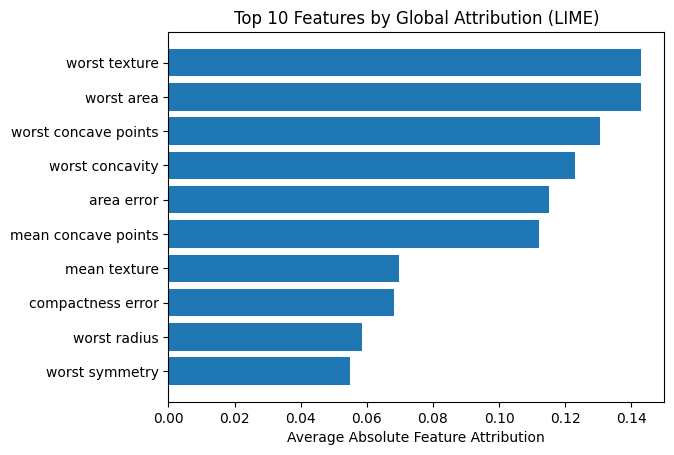

In [8]:
#Plot of Top 10 Features by Global Attribution using LIME

plot_global_feature_importance(lime_global_importance, "LIME", data.feature_names)

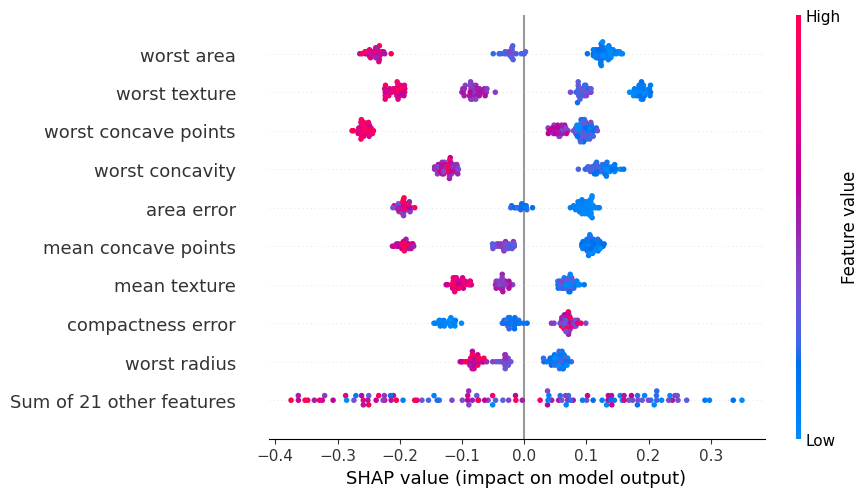

In [9]:
feature_names = data.feature_names #Saving the feature names for plotting

# Create the explainer
lime_explainer = LimeTabularExplainer(X_train, training_labels=y_train, mode='classification', feature_names=data.feature_names)

def return_weights(exp):
    """Get weights from LIME explanation object"""
    exp_list = exp.as_map()[1]
    exp_list = sorted(exp_list, key=lambda x: x[0])
    exp_weight = [x[1] for x in exp_list]
    return exp_weight


weights = []
list_exp = []

#Iterate over first 100 rows in feature matrix
for i in range (len(X_test)):

    #Get explanation
    exp = lime_explainer.explain_instance(X_test[i], model.predict_proba, num_features=len(data.feature_names))
    list_exp.append(exp)

    #Get weights
    exp_weight = return_weights(exp)
    weights.append(exp_weight)

#Create DataFrame
lime_weights = pd.DataFrame(data=weights,columns=data.feature_names)

#Get SHAP values
explainer = shap.Explainer(model)
shap_values = explainer(X_test)

#Replace SHAP values with LIME weights
shap_placeholder = explainer(X_test)
shap_placeholder.values = np.array(lime_weights)
shap_placeholder.feature_names = data.feature_names



shap.plots.beeswarm(shap_placeholder)


In [10]:
# Create confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = conf_matrix.ravel()  # True Negatives, False Positives, False Negatives, True Positives

# Find the most confident predictions for each category
true_positive_indices = np.where((y_test == 1) & (y_pred == 1))[0]
true_negative_indices = np.where((y_test == 0) & (y_pred == 0))[0]
false_positive_indices = np.where((y_test == 0) & (y_pred == 1))[0]
false_negative_indices = np.where((y_test == 1) & (y_pred == 0))[0]

# Identify the most confident predictions
tp_index = true_positive_indices[np.argmax(y_pred_proba[true_positive_indices])]
tn_index = true_negative_indices[np.argmin(y_pred_proba[true_negative_indices])]
fp_index = false_positive_indices[np.argmax(y_pred_proba[false_positive_indices])]
fn_index = false_negative_indices[np.argmin(y_pred_proba[false_negative_indices])]




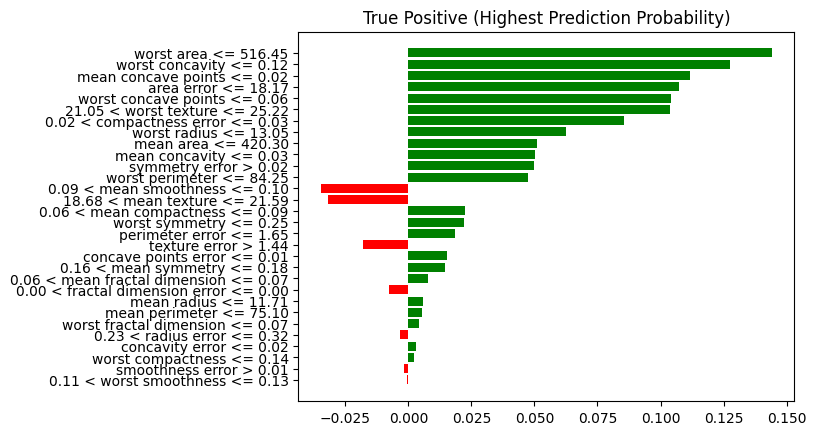

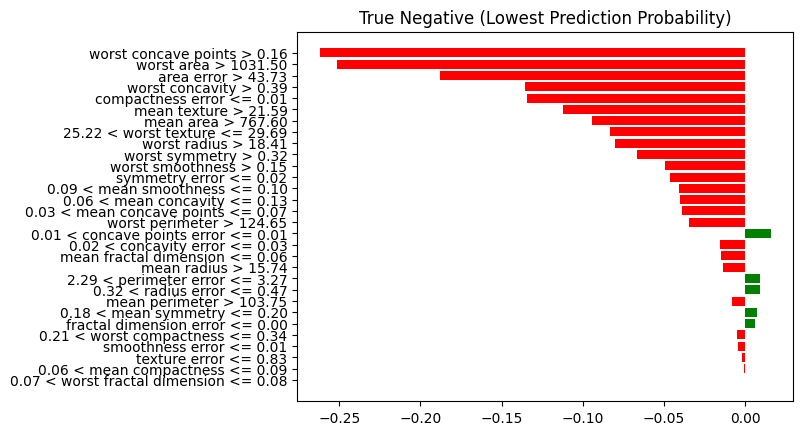

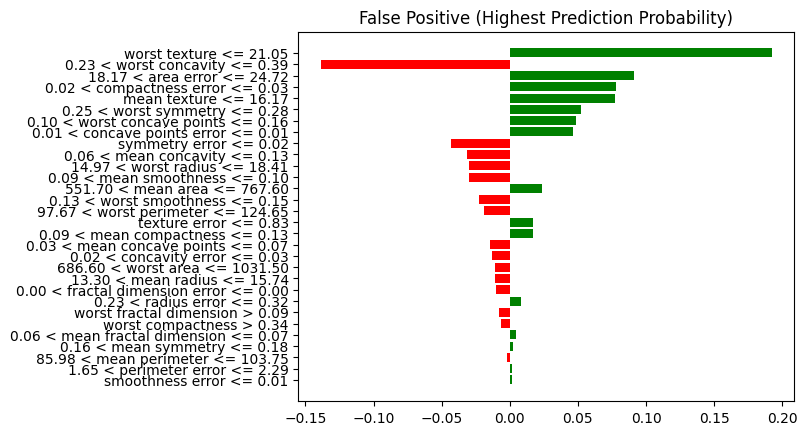

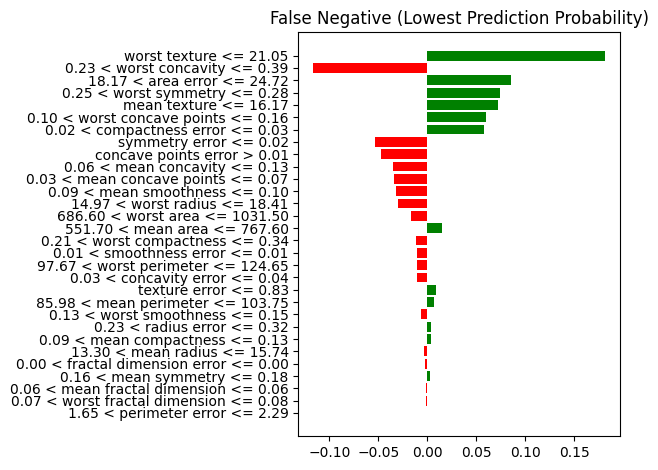

In [11]:
# Use LIME's `show_in_notebook()` for LIME explanations, or use `as_pyplot_figure` for plots

shap_values_tp = lime_explainer.explain_instance(X_test[tp_index], model.predict_proba, num_features=len(data.feature_names))
shap_values_tp.as_pyplot_figure()
plt.title("True Positive (Highest Prediction Probability)")

shap_values_tn = lime_explainer.explain_instance(X_test[tn_index], model.predict_proba, num_features=len(data.feature_names))
shap_values_tn.as_pyplot_figure()
plt.title("True Negative (Lowest Prediction Probability)")

shap_values_fp = lime_explainer.explain_instance(X_test[fp_index], model.predict_proba, num_features=len(data.feature_names))
shap_values_fp.as_pyplot_figure()
plt.title("False Positive (Highest Prediction Probability)")

shap_values_fn = lime_explainer.explain_instance(X_test[fn_index], model.predict_proba, num_features=len(data.feature_names))
shap_values_fn.as_pyplot_figure()
plt.title("False Negative (Lowest Prediction Probability)")

plt.tight_layout()
plt.show()


In [12]:


# Assuming shap_values_tp is the result of lime_explainer.explain_instance
# and we want to create a force plot from it.

def create_force_plot_from_lime(lime_explanation, X_instance, feature_names):


    # Extract the contributions (weights) from the LIME explanation
    # lime_explanation.as_list() returns a list of tuples (feature_name, contribution)
    lime_feature_contributions = lime_explanation.as_map()[1]  # LIME returns the importance for class 1

    # Convert the LIME contributions to an array for SHAP
    lime_shap_values = np.zeros(len(feature_names))
    for feature_index, contribution in lime_feature_contributions:
        lime_shap_values[feature_index] = contribution

    # SHAP force plot
    shap.initjs()
    force_plot = shap.plots.force(
        base_value=lime_explanation.intercept[1],  # Intercept for class 1
        shap_values=lime_shap_values,
        features=X_instance,
        feature_names=feature_names
    )
    display(force_plot)

# Example usage:
shap_values_tp = lime_explainer.explain_instance(X_test[tp_index], model.predict_proba, num_features=len(data.feature_names))
shap_values_tn = lime_explainer.explain_instance(X_test[tn_index], model.predict_proba, num_features=len(data.feature_names))
shap_values_fp = lime_explainer.explain_instance(X_test[fp_index], model.predict_proba, num_features=len(data.feature_names))
shap_values_fn = lime_explainer.explain_instance(X_test[fn_index], model.predict_proba, num_features=len(data.feature_names))

create_force_plot_from_lime(shap_values_tp, X_test[tp_index], data.feature_names)
create_force_plot_from_lime(shap_values_tn, X_test[tn_index], data.feature_names)
create_force_plot_from_lime(shap_values_fp, X_test[fp_index], data.feature_names)
create_force_plot_from_lime(shap_values_fn, X_test[fn_index], data.feature_names)


### KernelSHAP

In [13]:
#Kernel Implementation

kernel_explainer = shap.KernelExplainer(model.predict_proba, X_train)
shap_values_kernel = kernel_explainer.shap_values(X_test)
kernel_global_importance = np.mean(np.abs(shap_values_kernel[1]), axis=1)

  0%|          | 0/114 [00:00<?, ?it/s]

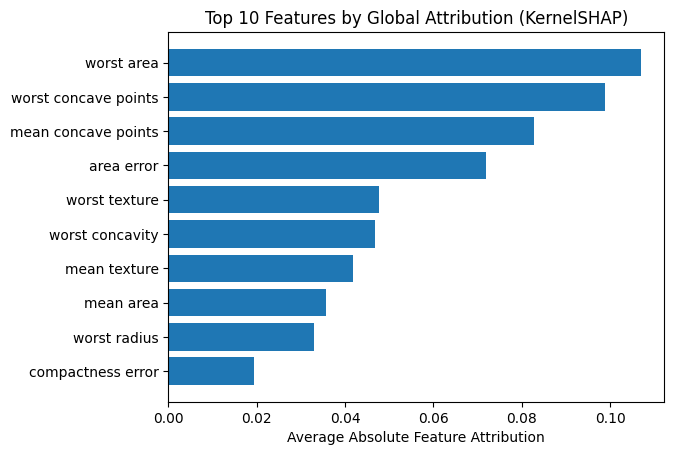

In [14]:
#Plot of Top 10 Features by Global Attribution using KernelSHAP

plot_global_feature_importance(kernel_global_importance, "KernelSHAP", data.feature_names)

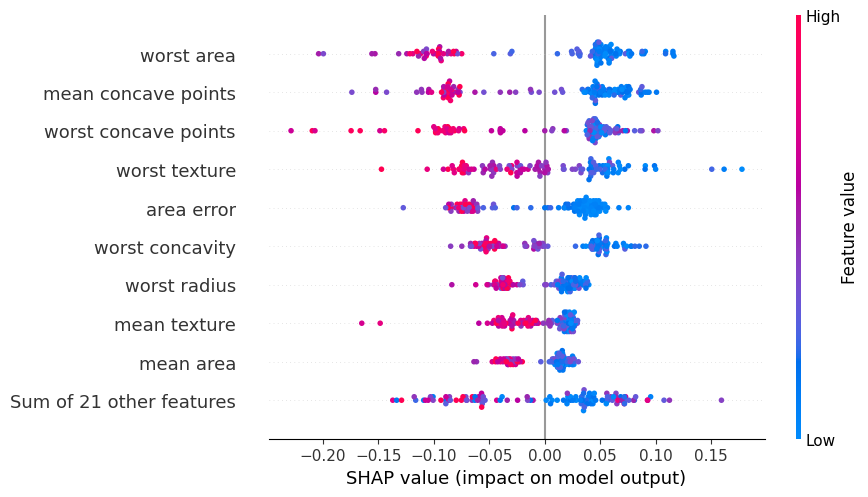

In [15]:
#Kernel Implementation

#Get SHAP values
explainer = shap.Explainer(model)
shap_values = explainer(X_test)

#Replace SHAP values with LIME weights
shap_placeholder = explainer(X_test)

shap_placeholder.values = shap_values_kernel[:,:,1]


shap_placeholder.feature_names = data.feature_names


shap.plots.beeswarm(shap_placeholder)


In [16]:
# Create confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = conf_matrix.ravel()  # True Negatives, False Positives, False Negatives, True Positives

# Find the most confident predictions for each category
true_positive_indices = np.where((y_test == 1) & (y_pred == 1))[0]
true_negative_indices = np.where((y_test == 0) & (y_pred == 0))[0]
false_positive_indices = np.where((y_test == 0) & (y_pred == 1))[0]
false_negative_indices = np.where((y_test == 1) & (y_pred == 0))[0]

# Identify the most confident predictions
tp_index = true_positive_indices[np.argmax(y_pred_proba[true_positive_indices])]
tn_index = true_negative_indices[np.argmin(y_pred_proba[true_negative_indices])]
fp_index = false_positive_indices[np.argmax(y_pred_proba[false_positive_indices])]
fn_index = false_negative_indices[np.argmin(y_pred_proba[false_negative_indices])]

# Prepare for SHAP Force Plots
explainer = shap.KernelExplainer(model.predict_proba, X_train)
# Generate SHAP values for the four cases
shap_values_tp = kernel_explainer.shap_values(X_test[tp_index].reshape(1, -1))[0, :, 1]
shap_values_tn = kernel_explainer.shap_values(X_test[tn_index].reshape(1, -1))[0, :, 1]
shap_values_fp = kernel_explainer.shap_values(X_test[fp_index].reshape(1, -1))[0, :, 0]
shap_values_fn = kernel_explainer.shap_values(X_test[fn_index].reshape(1, -1))[0, :, 1]


# Expected values for each class (class 1 for positive case, class 0 for negative case)
expected_value_tp = kernel_explainer.expected_value[1]  # For class 1
expected_value_tn = kernel_explainer.expected_value[1]  # For class 0
expected_value_fp = kernel_explainer.expected_value[0]  # For class 1 (False positive is a predicted positive)
expected_value_fn = kernel_explainer.expected_value[1] # For class 0 (False negative is a predicted negative)

# Print or store the expected values for each case
print("Expected Value for True Positive:", expected_value_tp)
print("Expected Value for True Negative:", expected_value_tn)
print("Expected Value for False Positive:", expected_value_fp)
print("Expected Value for False Negative:", expected_value_fn)

# Print the shapes of SHAP values
print("Shape of SHAP values for True Positive:", np.array(shap_values_tp).shape)
print("Shape of SHAP values for True Negative:", np.array(shap_values_tn).shape)
print("Shape of SHAP values for False Positive:", np.array(shap_values_fp).shape)
print("Shape of SHAP values for False Negative:", np.array(shap_values_fn).shape)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Expected Value for True Positive: 0.6285710701723084
Expected Value for True Negative: 0.6285710701723084
Expected Value for False Positive: 0.3714289290564401
Expected Value for False Negative: 0.6285710701723084
Shape of SHAP values for True Positive: (30,)
Shape of SHAP values for True Negative: (30,)
Shape of SHAP values for False Positive: (30,)
Shape of SHAP values for False Negative: (30,)


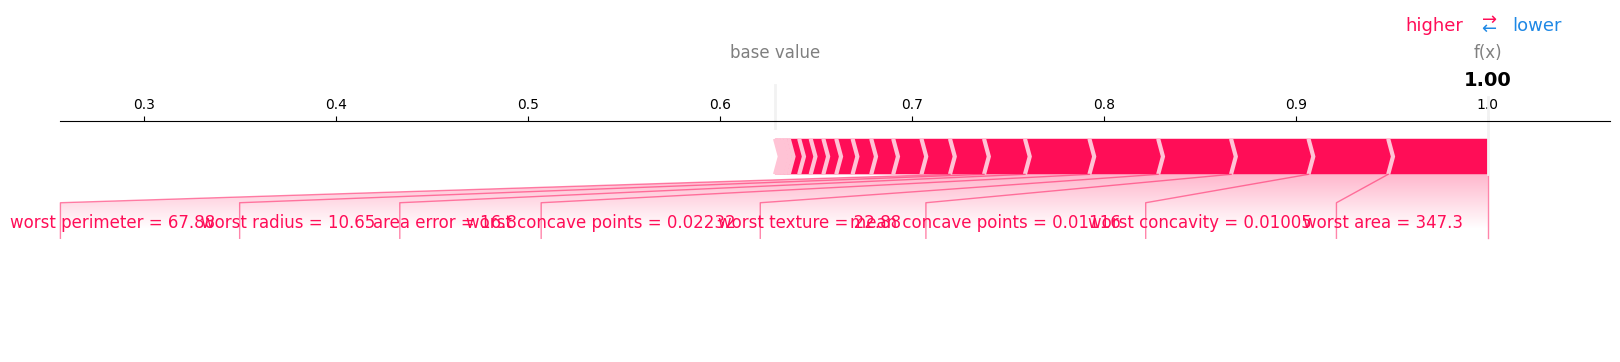

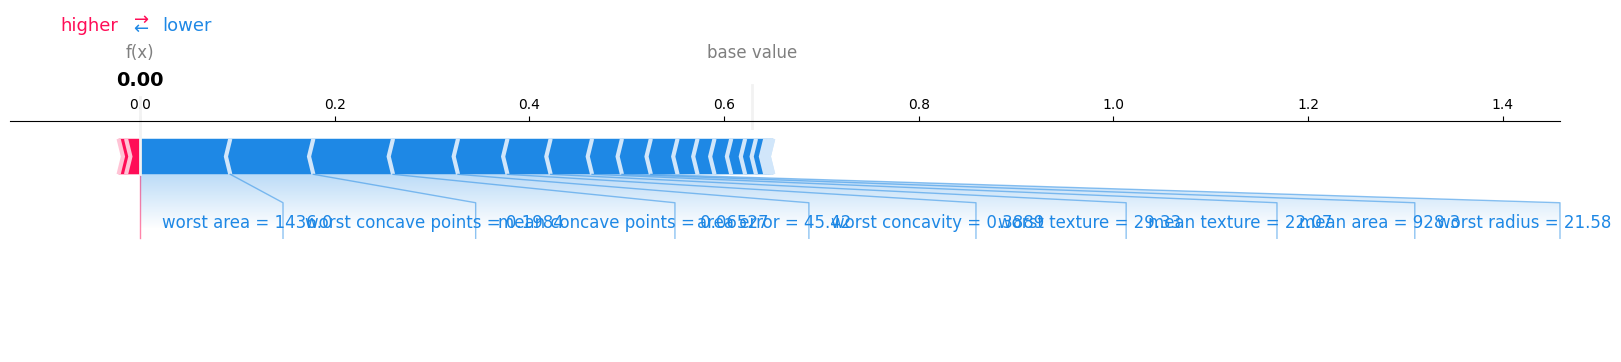

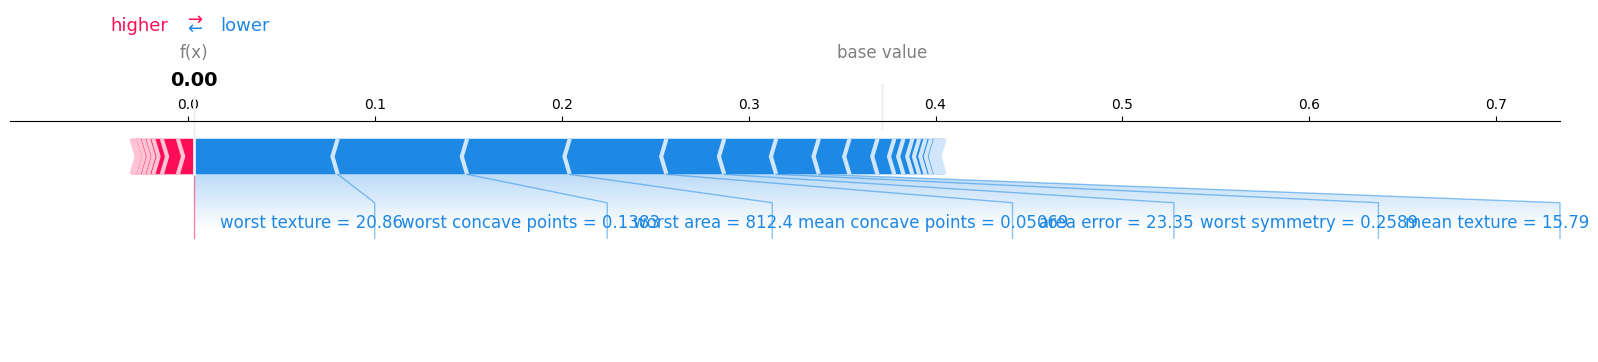

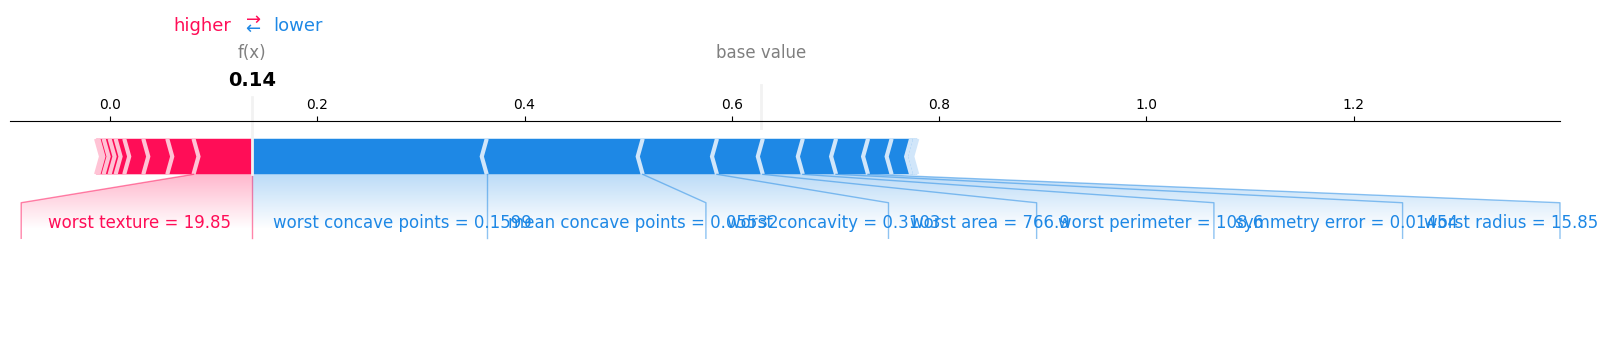

In [17]:
# Plot SHAP force plots for the four cases

shap.force_plot(expected_value_tp, shap_values_tp, X_test[tp_index].reshape(1, -1), matplotlib=True, feature_names = feature_names)

shap.force_plot(expected_value_tn, shap_values_tn, X_test[tn_index].reshape(1, -1), matplotlib=True, feature_names = feature_names)

shap.force_plot(expected_value_fp, shap_values_fp, X_test[fp_index].reshape(1, -1), matplotlib=True, feature_names = feature_names)

shap.force_plot(expected_value_fn, shap_values_fn, X_test[fn_index].reshape(1, -1), matplotlib=True, feature_names = feature_names)




### TreeSHAP

In [18]:
#TreeSHAP Implementation

tree_explainer = shap.TreeExplainer(model, X_train)
shap_values_tree = tree_explainer.shap_values(X_test)
tree_global_importance = np.mean(np.abs(shap_values_tree), axis=0)

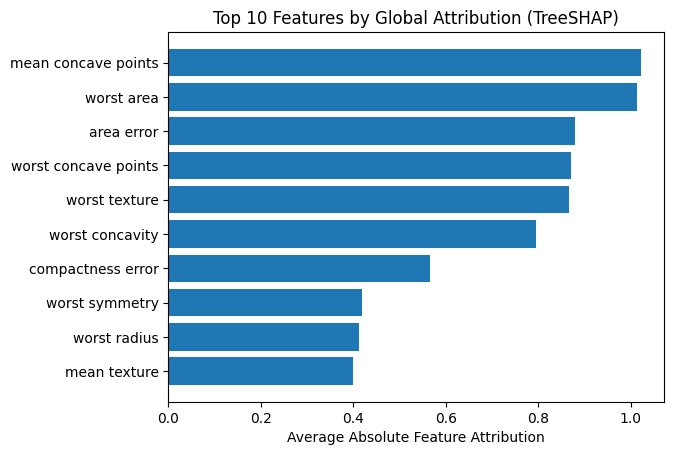

In [19]:
#Plot of Top 10 Features by Global Attribution using TreeSHAP

plot_global_feature_importance(tree_global_importance, "TreeSHAP", data.feature_names)

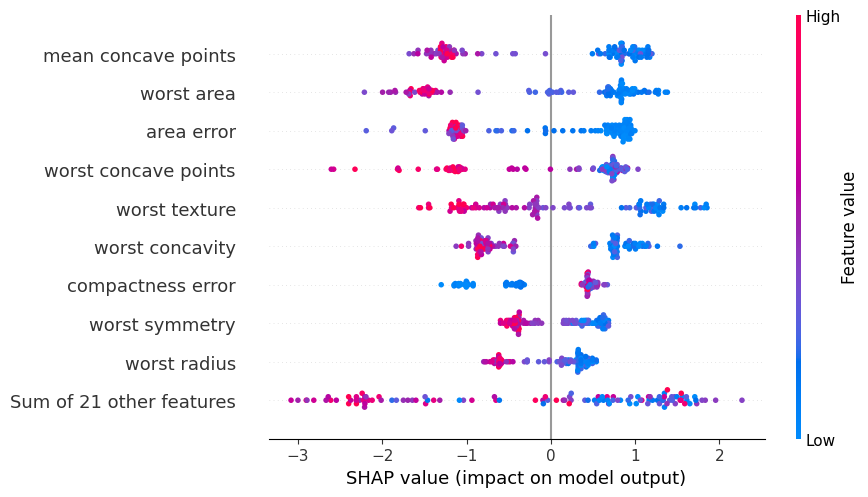

In [20]:
# Beeswarm plot:

shap_values = tree_explainer(X_test)
shap_values.feature_names = data.feature_names
shap.plots.beeswarm(shap_values)

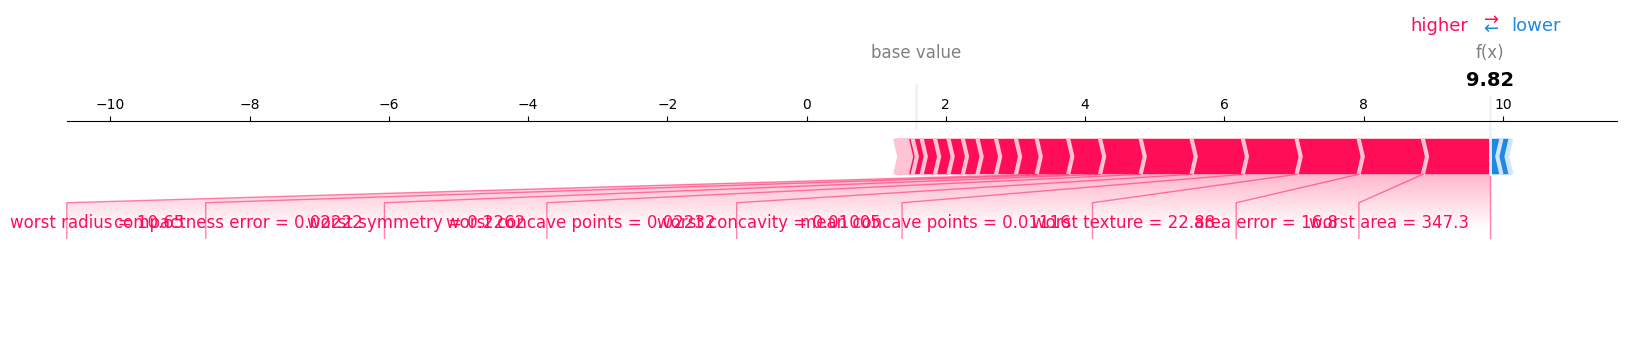

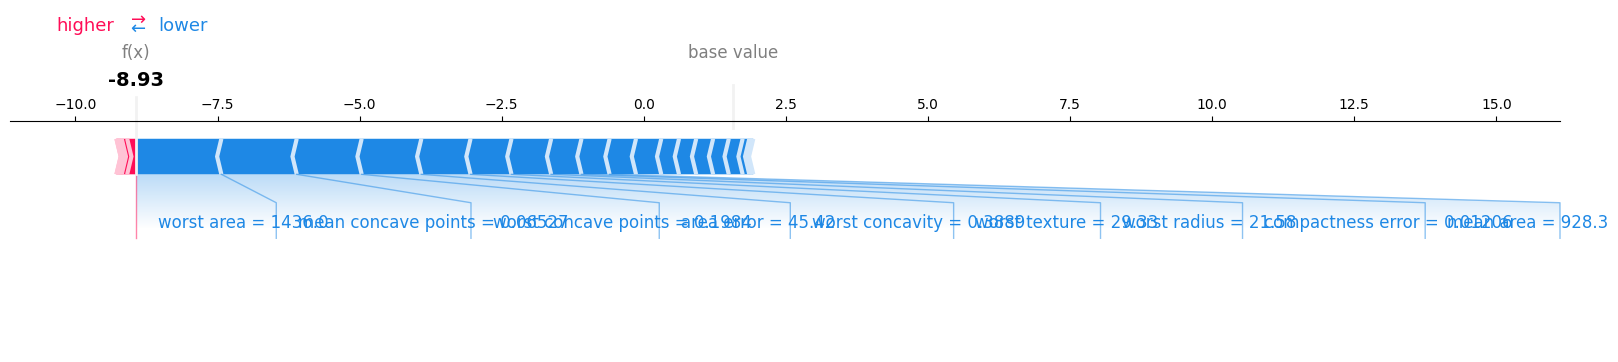

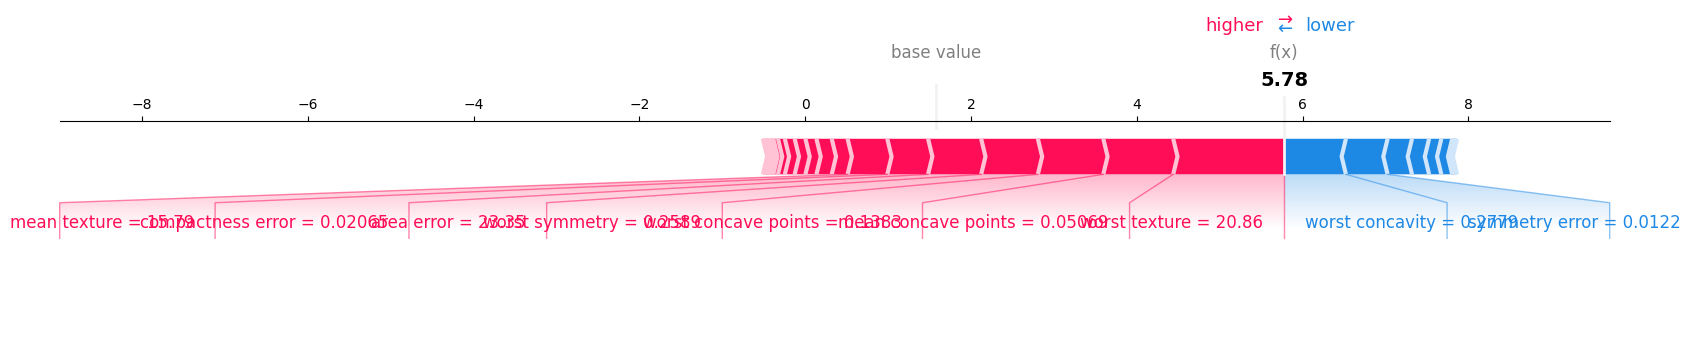

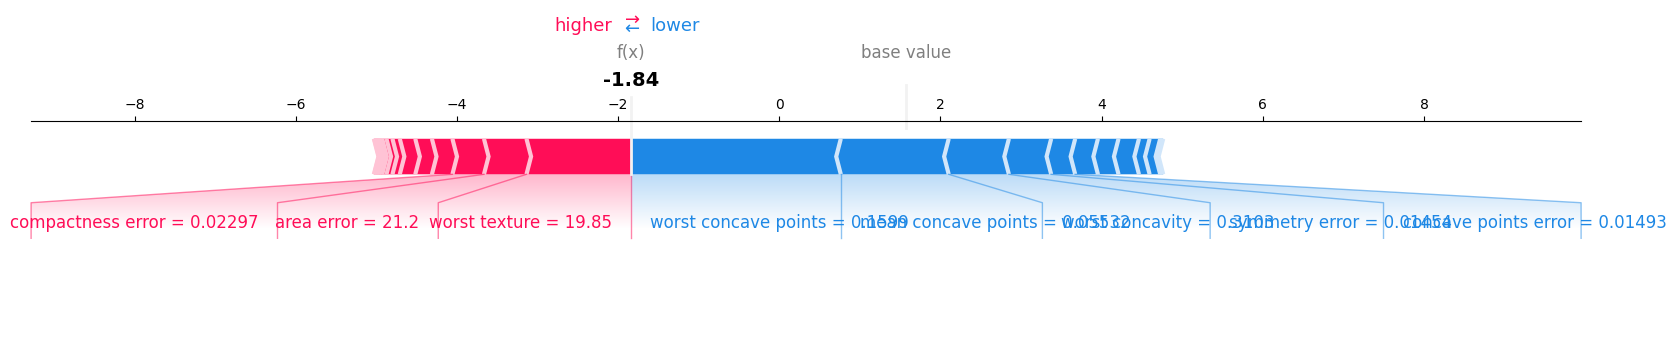

In [21]:
# Create confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = conf_matrix.ravel()  # True Negatives, False Positives, False Negatives, True Positives

# Find the most confident predictions for each category
true_positive_indices = np.where((y_test == 1) & (y_pred == 1))[0]
true_negative_indices = np.where((y_test == 0) & (y_pred == 0))[0]
false_positive_indices = np.where((y_test == 0) & (y_pred == 1))[0]
false_negative_indices = np.where((y_test == 1) & (y_pred == 0))[0]

# Identify the most confident predictions
tp_index = true_positive_indices[np.argmax(y_pred_proba[true_positive_indices])]
tn_index = true_negative_indices[np.argmin(y_pred_proba[true_negative_indices])]
fp_index = false_positive_indices[np.argmax(y_pred_proba[false_positive_indices])]
fn_index = false_negative_indices[np.argmin(y_pred_proba[false_negative_indices])]

# Prepare for SHAP Force Plots
explainer = tree_explainer
shap_values_tp = explainer(X_test[tp_index].reshape(1, -1))
shap_values_tn = explainer(X_test[tn_index].reshape(1, -1))
shap_values_fp = explainer(X_test[fp_index].reshape(1, -1))
shap_values_fn = explainer(X_test[fn_index].reshape(1, -1))


# Plotting the force plots

shap.plots.force(shap_values_tp, matplotlib=True, feature_names = feature_names)

shap.plots.force(shap_values_tn, matplotlib=True, feature_names = feature_names)

shap.plots.force(shap_values_fp, matplotlib=True, feature_names = feature_names)

shap.plots.force(shap_values_fn, matplotlib=True, feature_names = feature_names)



Additional plots:

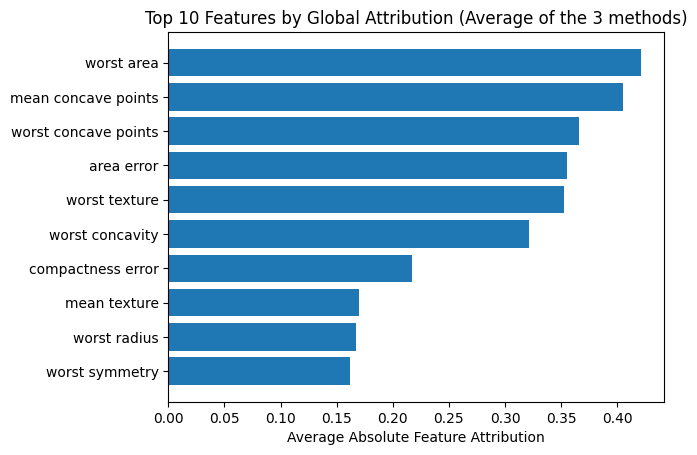

In [25]:
#Calculating the average importance of all 3 methods:
avg_importance = np.mean([lime_global_importance, kernel_global_importance, tree_global_importance], axis = 0)

plot_global_feature_importance(avg_importance, "Average of the 3 methods", data.feature_names)

# 2 Question 2. xAI on sequence predictions of RNA splicing

Epoch 1/50, Test Accuracy: 0.9091
Epoch 2/50, Test Accuracy: 0.9248
Epoch 3/50, Test Accuracy: 0.9248
Epoch 4/50, Test Accuracy: 0.9498
Epoch 5/50, Test Accuracy: 0.9436
Epoch 6/50, Test Accuracy: 0.9436
Epoch 7/50, Test Accuracy: 0.9498
Epoch 8/50, Test Accuracy: 0.9404
Epoch 9/50, Test Accuracy: 0.9342
Epoch 10/50, Test Accuracy: 0.9436
Epoch 11/50, Test Accuracy: 0.9373
Epoch 12/50, Test Accuracy: 0.9373
Epoch 13/50, Test Accuracy: 0.9279
Epoch 14/50, Test Accuracy: 0.9373
Epoch 15/50, Test Accuracy: 0.9373
Epoch 16/50, Test Accuracy: 0.9342
Epoch 17/50, Test Accuracy: 0.9373
Epoch 18/50, Test Accuracy: 0.9436
Epoch 19/50, Test Accuracy: 0.9373
Epoch 20/50, Test Accuracy: 0.9530
Epoch 21/50, Test Accuracy: 0.9498
Epoch 22/50, Test Accuracy: 0.9342
Epoch 23/50, Test Accuracy: 0.9498
Epoch 24/50, Test Accuracy: 0.9467
Epoch 25/50, Test Accuracy: 0.9404
Epoch 26/50, Test Accuracy: 0.9373
Epoch 27/50, Test Accuracy: 0.9373
Epoch 28/50, Test Accuracy: 0.9404
Epoch 29/50, Test Accuracy: 0

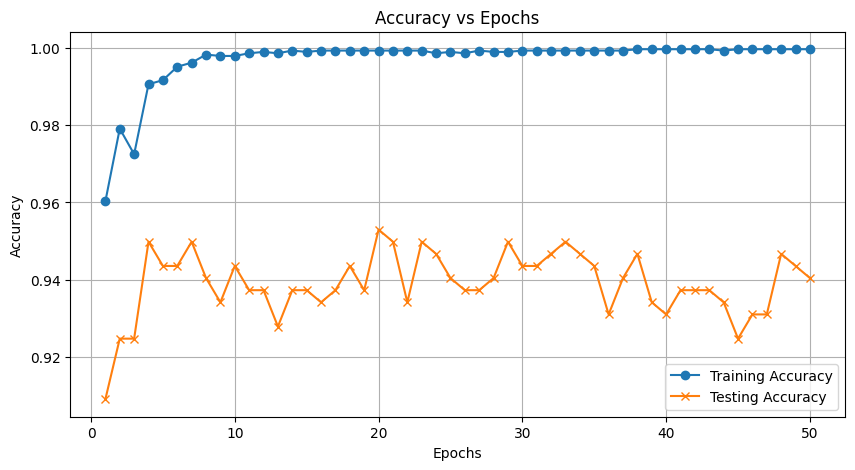

Real class 0 and predicted class 0


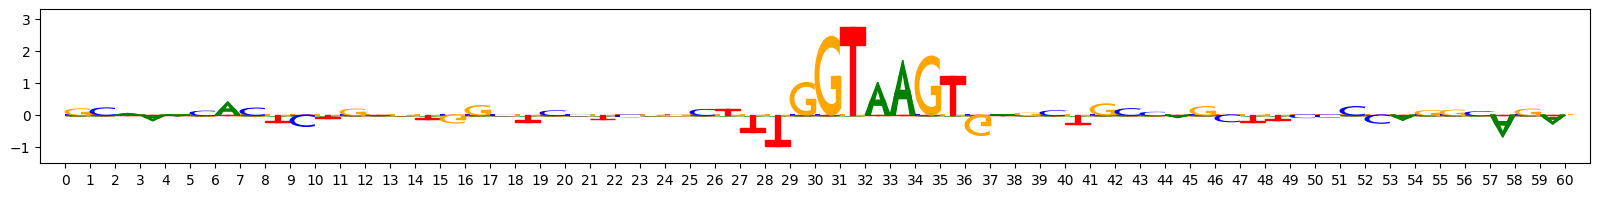

Real class 0 and predicted class 1


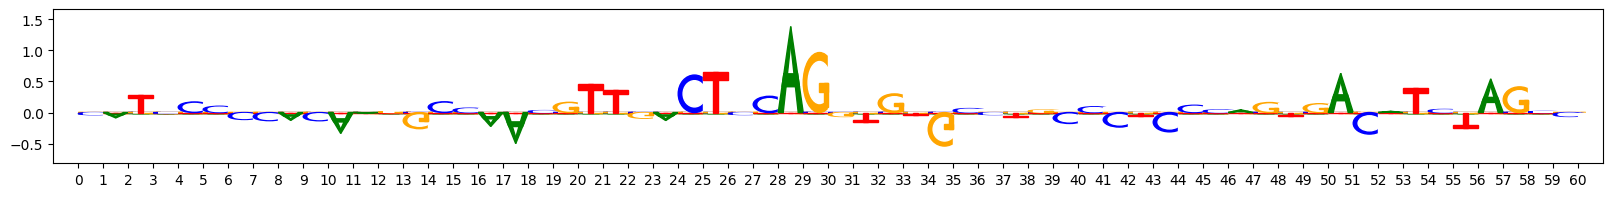

Real class 0 and predicted class 2


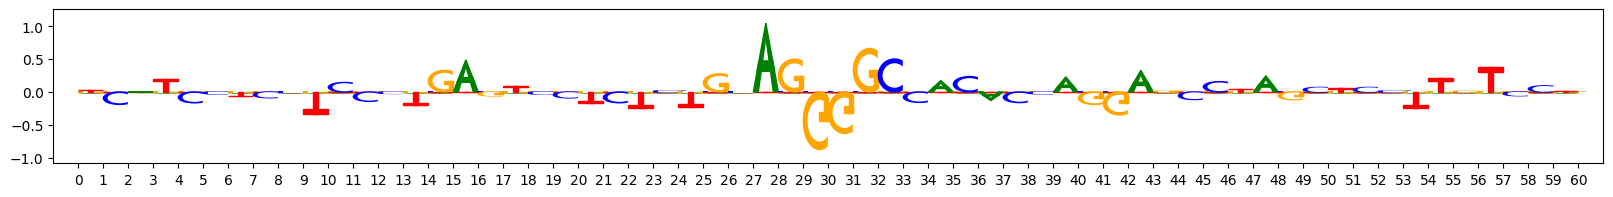

Real class 1 and predicted class 0


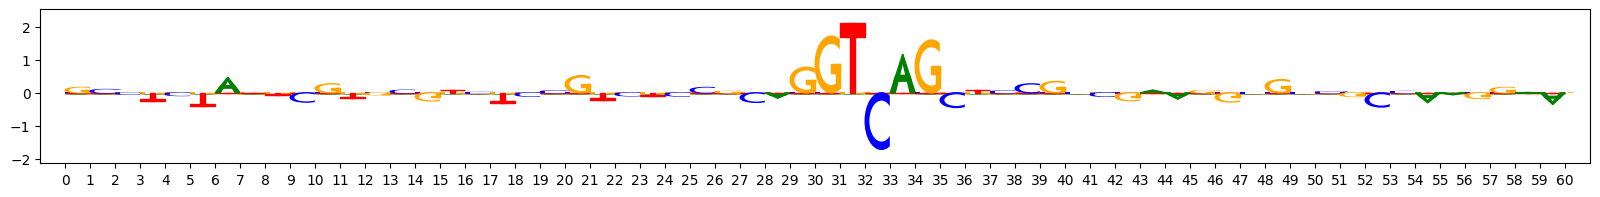

Real class 1 and predicted class 1


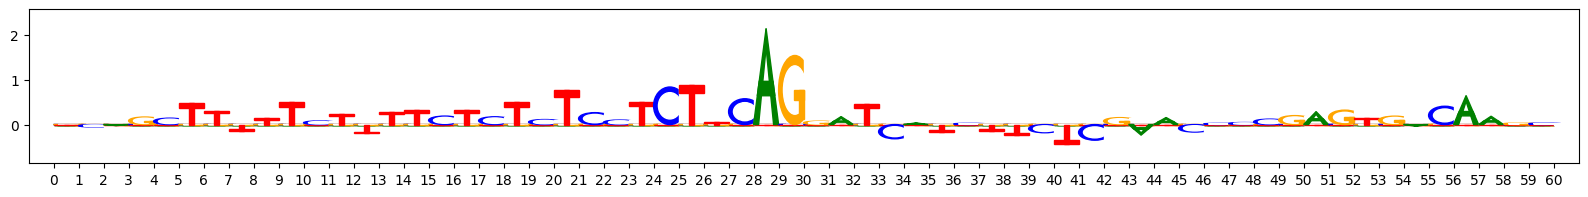

Real class 1 and predicted class 2


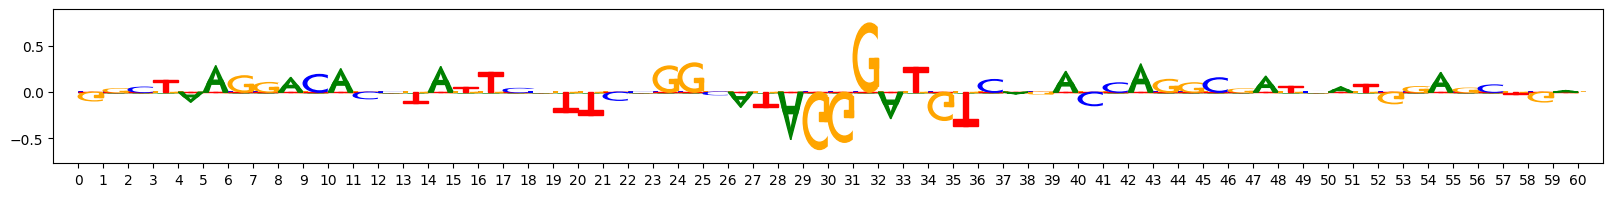

Real class 2 and predicted class 0


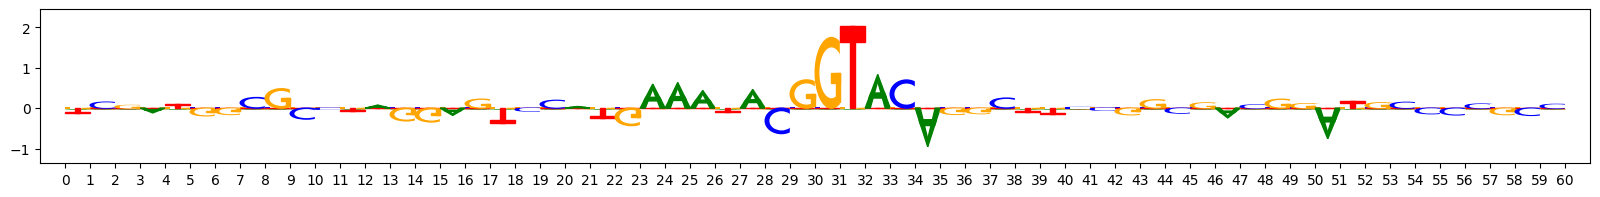

Real class 2 and predicted class 1


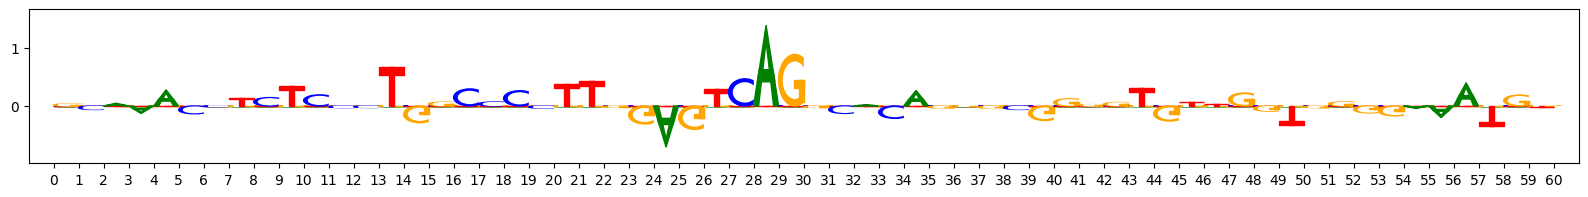

Real class 2 and predicted class 2


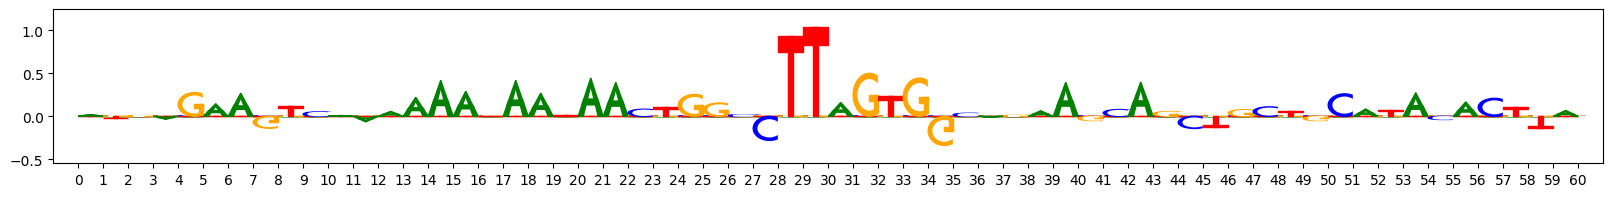

In [22]:

# CNN model
class SpliceCNN(nn.Module):
    def __init__(self, input_size, num_classes, kernel_size=5):
        super(SpliceCNN, self).__init__()
        self.conv1 = nn.Conv1d(4, 8, kernel_size=kernel_size, padding=0)
        self.fc1 = nn.Linear(8 * (input_size - kernel_size + 1), 64)
        self.bn1 = nn.BatchNorm1d(64)
        self.fc2 = nn.Linear(64, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv1(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.bn1(x)
        x = self.fc2(x)
        return x


# nucleotide dataset class
class SpliceDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = labels

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        seq = self.sequences[idx]
        label = self.labels[idx]
        return seq, label


# one-hot DNA encoder
def encode_dna(seq):
    encoding = {'A': [1,0,0,0],
                'C': [0,1,0,0],
                'G': [0,0,1,0],
                'T': [0,0,0,1],
                'D': [1/3,0,1/3,1/3],
                'N': [1/4,1/4,1/4,1/4],
                'S': [0,1/2,1/2,0],
                'R': [1/2,0,1/2,0]}

    return np.array([encoding.get(base, [0,0,0,0]) for base in seq])


# load and encoder sequence data
def load_data():
    # fetch dataset
    raw_sequences = fetch_ucirepo(id=69)

    # extract DNA sequences and labels
    sequences = raw_sequences.data.features.values
    labels = raw_sequences.data.targets.values.reshape(-1,)

    le = LabelEncoder()
    y = le.fit_transform(labels)

    # to torch tensor
    encoded_sequences = np.array([encode_dna(seq) for seq in sequences])
    encoded_sequences = torch.FloatTensor(encoded_sequences).permute(0, 2, 1)
    labels = torch.LongTensor(y)

    return encoded_sequences, labels


def train_model(model, train_loader, criterion, optimizer, device):
    model.train()

    for sequences, labels in train_loader:
        optimizer.zero_grad()

        # forward pass
        sequences, labels = sequences.to(device), labels.to(device)
        outputs = model(sequences)

        loss = criterion(outputs, labels)

        # backward pass
        loss.backward()
        optimizer.step()


def evaluate_model(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for sequences, labels in test_loader:
            sequences, labels = sequences.to(device), labels.to(device)
            outputs = model(sequences)

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()


    classification_accuracy = correct / total

    return classification_accuracy



def deeplift_analysis(model, encoded_sequences, device, X_train, X_test, y_train, y_test):
    # Ensure the model is in evaluation mode
    model.eval()

    # Move data to the appropriate device (GPU/CPU)
    X_test = X_test.to(device)
    y_test = y_test.to(device)
    model.to(device)

    # Compute the predictions on the test set
    with torch.no_grad():
        predictions = model(X_test)
        outputs = F.softmax(predictions, dim=1)
    num_points = len(X_test)

    # Initialize the sets for actual and predicted classes
    actualA = set([i for i in range(num_points) if y_test[i] == 0])
    actualB = set([i for i in range(num_points) if y_test[i] == 1])
    actualC = set([i for i in range(num_points) if y_test[i] == 2])

    predictedA = set([i for i in range(num_points) if torch.argmax(outputs[i]).item() == 0])
    predictedB = set([i for i in range(num_points) if torch.argmax(outputs[i]).item() == 1])
    predictedC = set([i for i in range(num_points) if torch.argmax(outputs[i]).item() == 2])

    # Initialize confusion matrix to store indices
    confusion_matrix_indices = np.zeros((3, 3))

    # Fill the confusion matrix with indices of representative examples
    for u, cl in enumerate([actualA, actualB, actualC]):
        for v, pred in enumerate([predictedA, predictedB, predictedC]):
            # Intersection of actual and predicted sets
            predictions_intersect = [(idx, outputs[idx][v].item()) for idx in cl.intersection(pred)]
            if predictions_intersect:
                # Store the index of the highest probability prediction for each class
                confusion_matrix_indices[u][v] = int(max(predictions_intersect, key=lambda x: x[1])[0])

    # Select sequences for explanation based on confusion matrix indices
    sequences_to_explain = X_test[confusion_matrix_indices.flatten().astype(int)]

    # Initialize SHAP's DeepExplainer with the model and encoded sequences
    deep_explainer = shap.DeepExplainer(model, encoded_sequences.to(device))

    # Compute SHAP values for the sequences to explain
    raw_shap_explanations = deep_explainer.shap_values(sequences_to_explain)

    # Plot explanations for each real and predicted class pair
    for u in range(3):
        for v in range(3):
            # Get the explanations and sequence to explain for class u and prediction v
            shap_explanations = raw_shap_explanations[:, :, :, v] * sequences_to_explain.cpu().numpy()
            idx = int(confusion_matrix_indices[u][v])

            # Generate the title for the plot
            title = f"Real class {u} and predicted class {v}"

            # Print the title and plot the SHAP explanations
            print(title)
            viz_sequence.plot_weights(shap_explanations[3 * u + v])








def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # load and preprocess data
    encoded_sequences, labels = load_data()

    # split data
    X_train, X_test, y_train, y_test = train_test_split(encoded_sequences, labels,
                                                        test_size=0.1, random_state=11)

    # dataloaders
    train_dataset = SpliceDataset(X_train, y_train)
    test_dataset = SpliceDataset(X_test, y_test)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # init model
    model = SpliceCNN(input_size=60, num_classes=3, kernel_size=4).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    # Lists to store accuracies
    train_accuracies = []
    test_accuracies = []

    # train model
    num_epochs = 50
    for epoch in range(num_epochs):
        train_model(model, train_loader, criterion, optimizer, device)

        accuracy = evaluate_model(model, test_loader, device)
        print(f"Epoch {epoch+1}/{num_epochs}, Test Accuracy: {accuracy:.4f}")


        # Calculate training accuracy
        train_accuracy = evaluate_model(model, train_loader, device)
        train_accuracies.append(train_accuracy)

        # Calculate test accuracy
        test_accuracy = evaluate_model(model, test_loader, device)
        test_accuracies.append(test_accuracy)



    # Plot accuracies
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy', marker='o')
    plt.plot(range(1, num_epochs + 1), test_accuracies, label='Testing Accuracy', marker='x')
    plt.title('Accuracy vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()
    plt.show()


    # perform DeepLIFT analysis
    deeplift_analysis(model, encoded_sequences, device, X_train, X_test, y_train, y_test)


if __name__ == "__main__":
    main()
